2.1 根据在图片上选择的点扣出物体

 导入依赖库和展示相关的函数：

In [2]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from segment_anything import sam_model_registry, SamPredictor
 
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30 / 255, 144 / 255, 255 / 255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
 
 
def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels == 1]
    neg_points = coords[labels == 0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white',
               linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white',
               linewidth=1.25)


确定使用的权重文件位置和是否使用cuda等：

In [8]:
sam_checkpoint = "./models/sam_vit_h_4b8939.pth"
device = "cpu"
model_type = "default"

模型实例化：

In [9]:
sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)
predictor = SamPredictor(sam)

读取图像并选择抠图点：

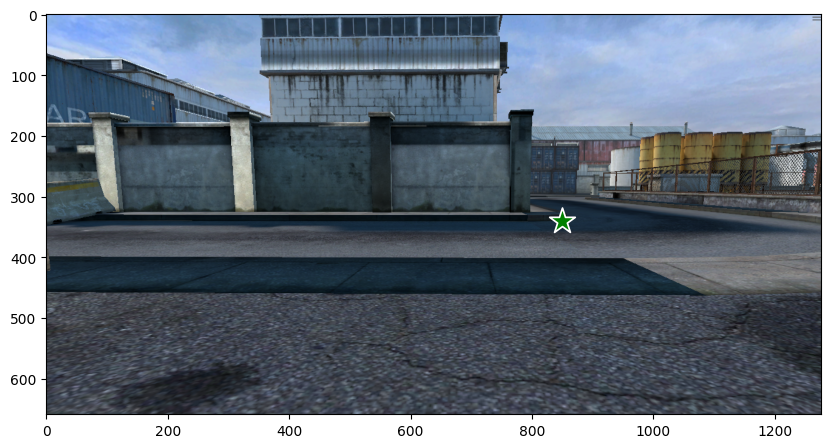

In [11]:
image = cv2.imread('test_fp.png')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
 
predictor.set_image(image)
 
input_point = np.array([[850, 340]])
input_label = np.array([1])
 
plt.figure(figsize=(10,10))
plt.imshow(image)
show_points(input_point, input_label, plt.gca())
plt.axis('on')
plt.show()


扣取图像（会同时提供多个扣取结果）：

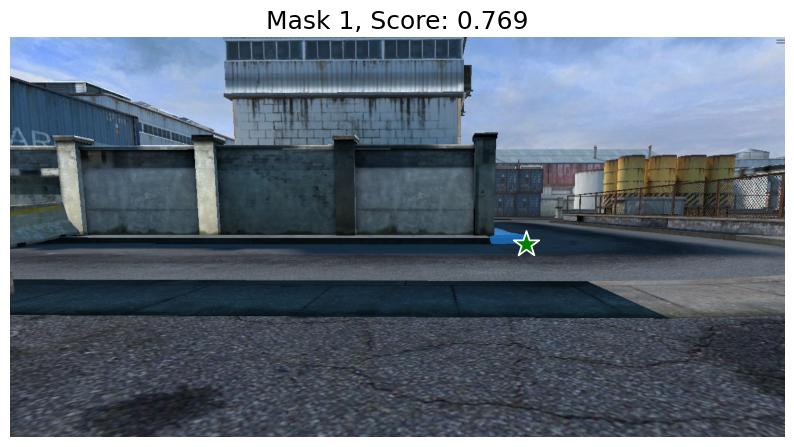

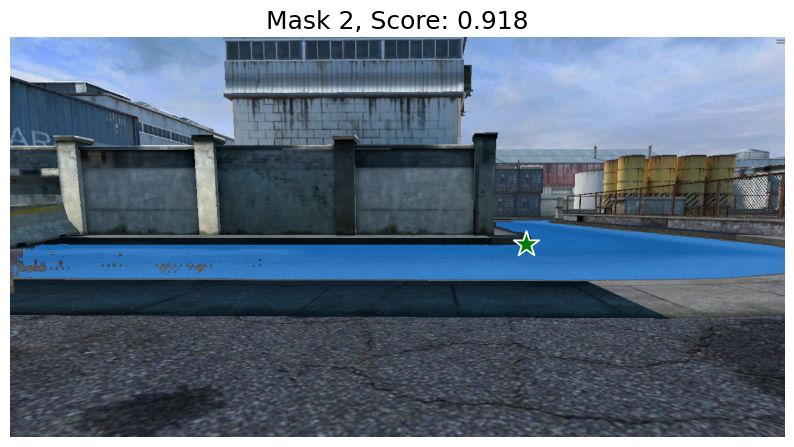

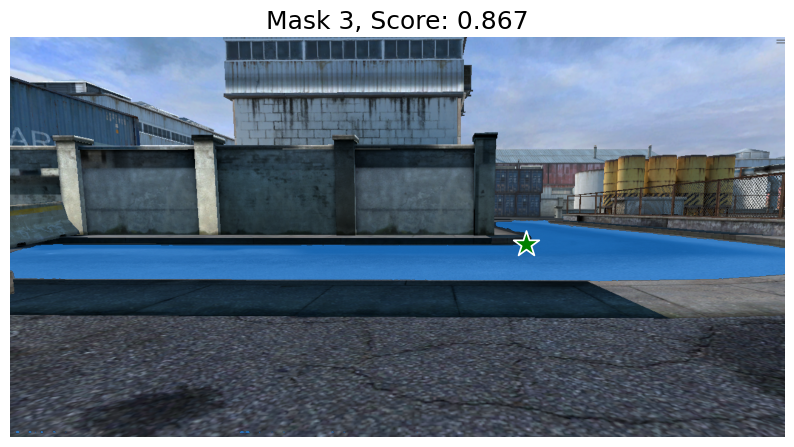

In [12]:

masks, scores, logits = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    multimask_output=True,
)
 
# 遍历读取每个扣出的结果
for i, (mask, score) in enumerate(zip(masks, scores)):
    plt.figure(figsize=(10,10))
    plt.imshow(image)
    show_mask(mask, plt.gca())
    show_points(input_point, input_label, plt.gca())
    plt.title(f"Mask {i+1}, Score: {score:.3f}", fontsize=18)
    plt.axis('off')
    plt.show()

2.2 扣取图像中的所有物体

In [14]:
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor
import cv2
import matplotlib.pyplot as plt
import numpy as np
 
def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)
    polygons = []
    color = []
    for ann in sorted_anns:
        m = ann['segmentation']
        img = np.ones((m.shape[0], m.shape[1], 3))
        color_mask = np.random.random((1, 3)).tolist()[0]
        for i in range(3):
            img[:,:,i] = color_mask[i]
        ax.imshow(np.dstack((img, m*0.35)))


In [15]:
sam_checkpoint = "./models/sam_vit_h_4b8939.pth"
device = "cpu"
model_type = "default"

In [16]:
sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)
predictor = SamPredictor(sam)

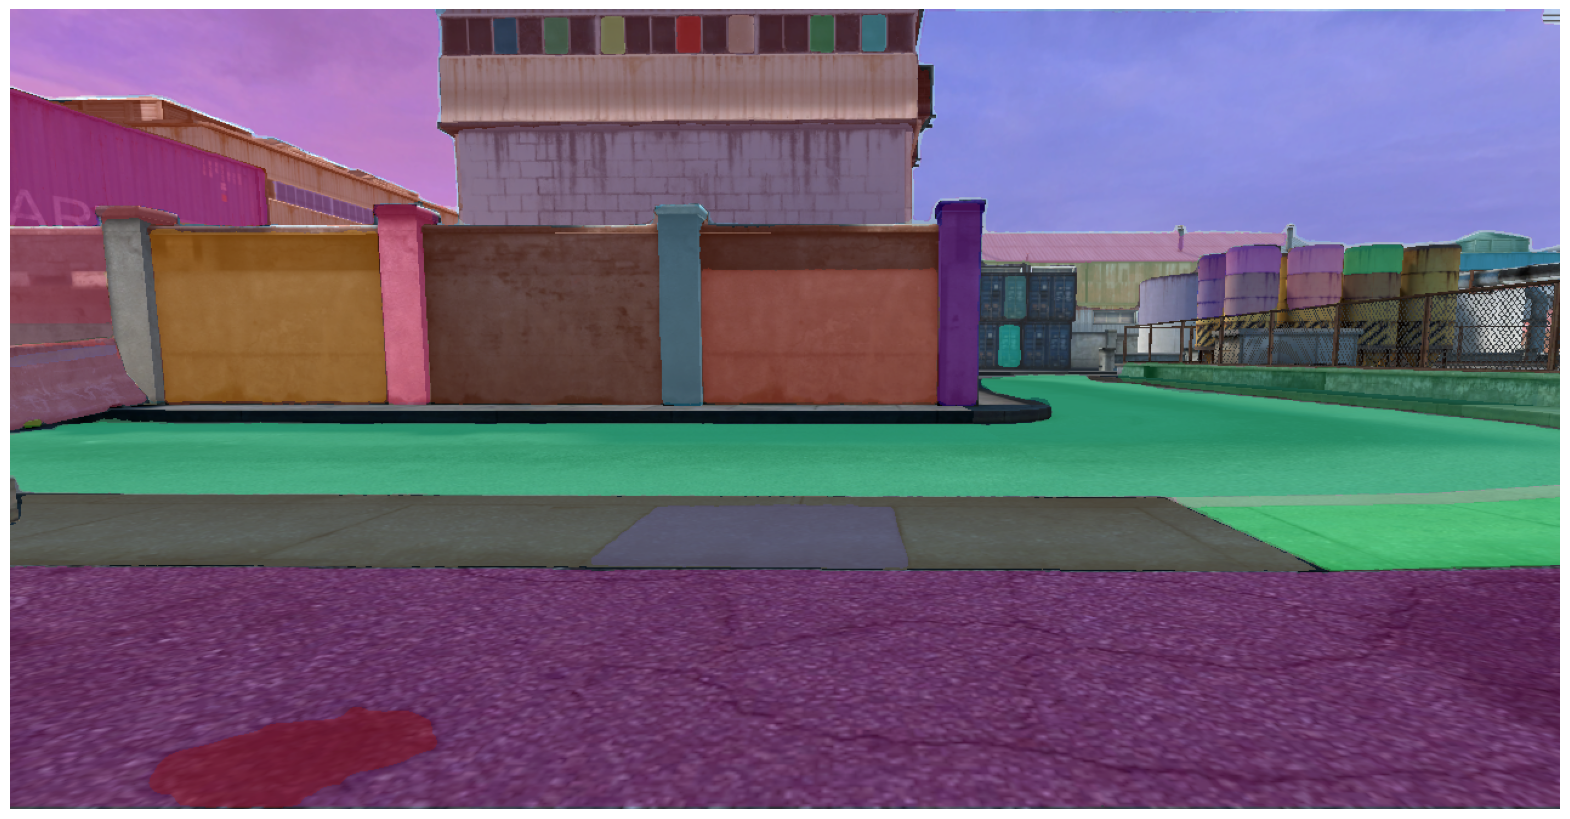

In [22]:
# mask_generator = SamAutomaticMaskGenerator(sam)

mask_generator = SamAutomaticMaskGenerator(
model=sam,
points_per_side=24,#default:32
pred_iou_thresh=0.88,#default:0.88
stability_score_thresh=0.95,#default:0.95
crop_n_layers=0,#default:0
crop_n_points_downscale_factor=1,#default:1
min_mask_region_area=100,  # Requires open-cv to run post-processing
)

masks = mask_generator.generate(image)

plt.figure(figsize=(20,20))
plt.imshow(image)
show_anns(masks)
plt.axis('off')
plt.show()